In [174]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from thinkdsp import *

In [175]:
# with tf.device('/cpu'):
model = tf.keras.models.load_model('distilled_model/my_model', compile=False)


https://stackoverflow.com/questions/63832644/any-tensorflow-equivalent-of-pytorchs-backward-trying-to-send-gradients-back

In [176]:
def tf_stft(x, y):
    # Ensure correct shape
    x = tf.squeeze(x, axis=-1)

    # Create a Spetrogram
    stft = tf.signal.stft(x, 
                          frame_length=1024, frame_step=512,
                          window_fn=tf.signal.hamming_window)
    # Take the same range of frequencies as in the pretrained model
    stft = stft[:, :, :int(stft.shape[2] * 5000 / (x.shape[1] // 2))]
    stft = tf.math.abs(stft)
    # Resize to the same shape as the input to the pretrained model
    stft = tf.repeat(stft, 16, axis=1)
    stft = tf.transpose(stft, perm=[2,1,0])[::-1]
    stft = tf.image.resize(stft, (369, 496))
    stft = tf.transpose(stft, perm=[2,0,1])

    # To 3-channel image (again, the same as the input to the pretrained model)
    stft = tf.expand_dims(stft, -1)
    stft = tf.image.grayscale_to_rgb(stft)
    
    return stft, tf.one_hot(y, 8)

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='test_audio',
    batch_size=1,
    seed=0,
    output_sequence_length=16000,
    )

Found 1599 files belonging to 8 classes.


In [ ]:
def gen_adv(x, y, max_frac=.15, eps=1e-2):
    y = y[0].numpy()
    # If the model already classifies this sample incorrectly - skip it
    tx, _ = tf_stft(x, y)
    pred = model(tx)
    pred_cls = tf.math.argmax(pred[0]).numpy()
    print("initially", pred_cls, y)
    if pred_cls != y:
        return x
    
    # Otherwise, start to generate an adversarial example
    # constraint on amount of entries that I can change
    slice_ = int(x.shape[1] * max_frac)
    delta = tf.zeros_like(x)
    for i in range(15):
        with tf.GradientTape() as tape:
            tape.watch(x)
            tx, ty = tf_stft(x - delta, y)
            pred = model(tx)
            cls = pred[0, y]
            loss = pred[0, y] + tf.math.reduce_mean(delta)
        

        plt.plot(pred[0].numpy())
        plt.title(f"Real class: {train_ds.class_names[y]}, {y}")
        plt.show()
        print(tf.math.reduce_max(pred[0]).numpy(), tf.math.argmax(pred[0]).numpy())

        if tf.math.reduce_max(pred[0]).numpy() > 0.9 and tf.math.argmax(pred[0]).numpy() != y:
            break

        grad = tape.gradient(loss, x)
        print(f"Gradient magnitude: {grad.numpy().sum()}")
        print(f"Predicted class prob: {cls.numpy()}")
        # I will change only first 15% of entries
        # Thus, I will take only top 15% of grad values with largest magnitudes
        # Other values of delta are zeroed out.
        if i == 0:
            values, top_indices = tf.math.top_k(tf.squeeze(grad, axis=-1), k=slice_)
            
        delta_ = tf.scatter_nd(indices=tf.expand_dims(top_indices[0], axis=-1), 
                              updates=tf.gather(grad[0, :, 0], indices=top_indices[0]),
                              shape=tf.constant([grad.shape[1]]))
        delta_ = tf.expand_dims(delta_, axis=0)
        delta_ = tf.expand_dims(delta_, axis=-1)
        delta += delta_
#         delta = tf.clip_by_value(delta + delta_, -eps, eps)
        
    return x - delta


In [116]:
for x, y in train_ds:
    break

initially 4 4


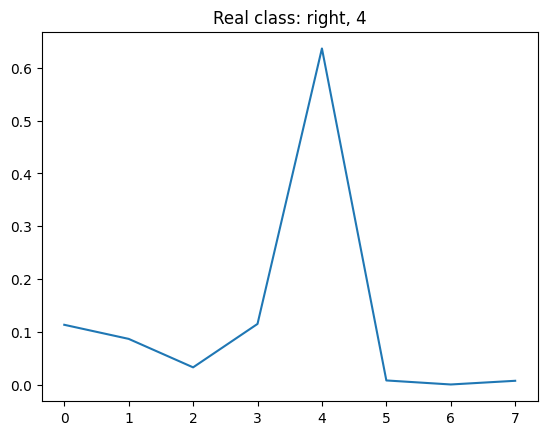

0.63634783 4
Gradient magnitude: 3.337860107421875e-06
Predicted class prob: 0.6363478302955627


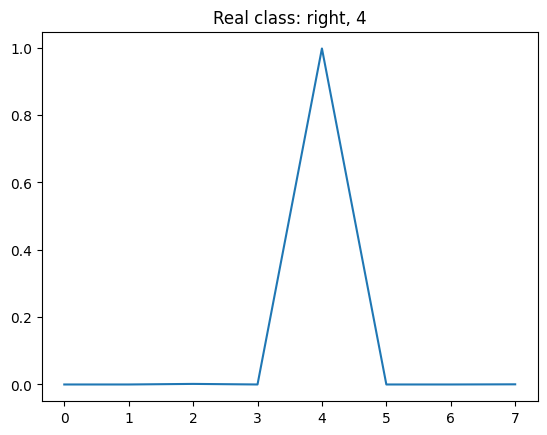

0.99782324 4
Gradient magnitude: -1.0673829820007086e-08
Predicted class prob: 0.9978232383728027


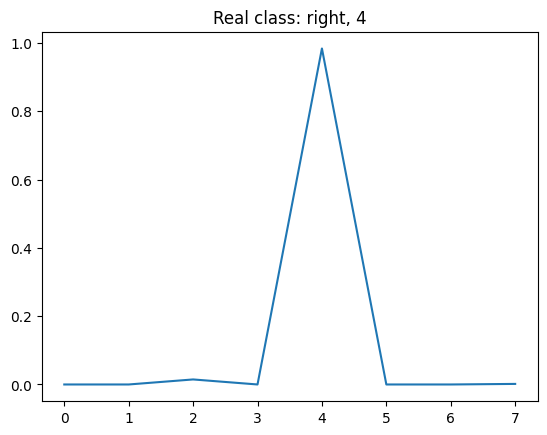

0.9835878 4
Gradient magnitude: 1.0337680578231812e-07
Predicted class prob: 0.9835878014564514


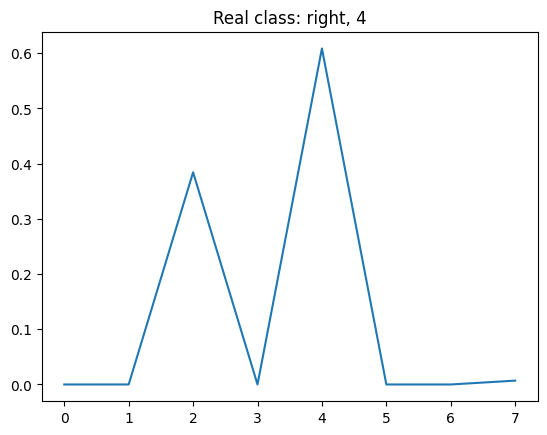

0.6086289 4
Gradient magnitude: -1.7508864402770996e-07
Predicted class prob: 0.6086289286613464


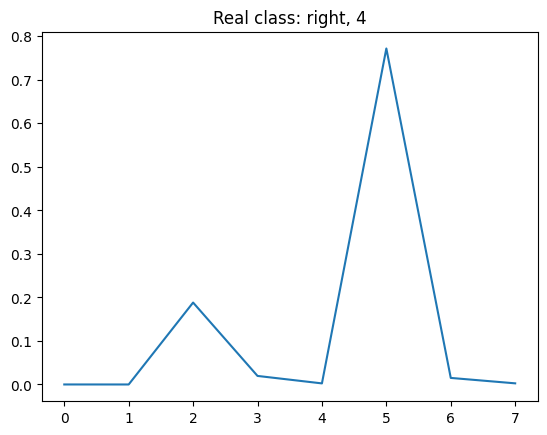

0.7719252 5
Gradient magnitude: 5.506444722414017e-08
Predicted class prob: 0.0024834992364048958


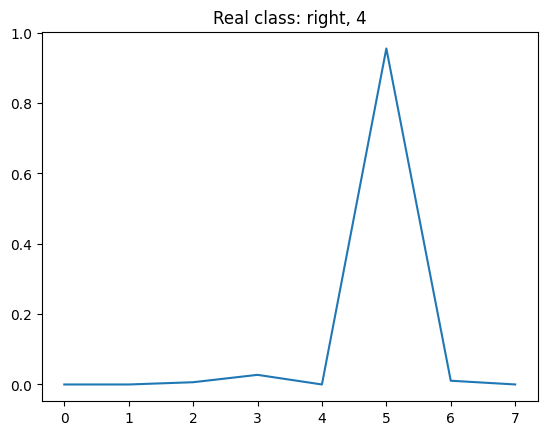

0.95548403 5


In [117]:
adv_x = gen_adv(x,y)

In [118]:
(x == adv_x).numpy().sum()

13600

In [119]:
train_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

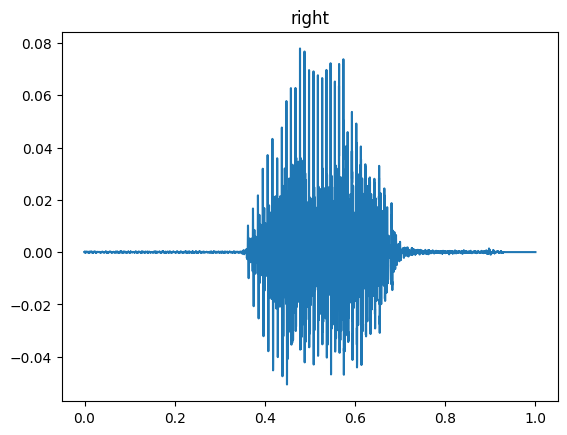

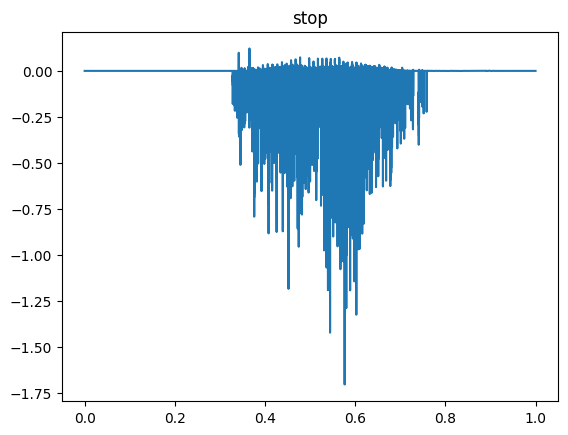

In [120]:
org_wave = Wave(ys=x[0,:,0].numpy(), framerate=16000)
org_cls = train_ds.class_names[tf.math.argmax(model(tf_stft(x, y)[0])[0]).numpy()]
# print(org_cls)
org_wave.plot()
plt.title(str(org_cls))
plt.show()
display(org_wave.make_audio())
adv_wave = Wave(ys=adv_x[0,:,0].numpy(), framerate=16000)
adv_cls = train_ds.class_names[tf.math.argmax(model(tf_stft(adv_x, y)[0])[0]).numpy()]
# print(adv_cls)
adv_wave.plot()
plt.title(str(adv_cls))
plt.show()
display(adv_wave.make_audio())

1.2732926e-10

In [ ]:
def orig_spec(x):
    wave = Wave(ys=x.numpy().flatten(), framerate=16000)
    wave.make_spectrogram(1024).plot(high=5000)
    plt.axis('off')
    plt.savefig('loh.png', bbox_inches='tight', pad_inches=0)
    with Image.open('loh.png') as img:
        img = np.asarray(img)[:,:,:3]
        
    return img

In [143]:
def gen_adv(x_, y, max_frac=.15, eps=1e-2):
    x = tf.Variable(tf.identity(x_))
    y = y[0].numpy()
    # If the model already classifies this sample incorrectly - skip it
    tx, _ = tf_stft(x, y)
    pred = model(tx)
    pred_cls = tf.math.argmax(pred[0]).numpy()
#     print("initially", pred_cls, y)
    if pred_cls != y:
        return x, None
    
    # Otherwise, start to generate an adversarial example
    # constraint on amount of entries that I can change
    slice_ = int(x.shape[1] * max_frac)
#     delta = tf.zeros_like(x)
    optimizer = tf.keras.optimizers.Adam()
    history = []
    for i in range(15):
        with tf.GradientTape() as tape:
            tape.watch(x)
            tx, ty = tf_stft(x, y)
            pred = model(tx)
            cls = pred[0, y]
            loss = pred[0, y]# + tf.math.reduce_mean((x - x_) ** 2)
#             print(np.all(x.numpy().flatten()  == x_.numpy().flatten()))
        

#         plt.plot(pred[0].numpy())
#         plt.title(f"Real class: {test_ds.class_names[y]}, {y}")
#         plt.show()
#         print(tf.math.reduce_max(pred[0]).numpy(), tf.math.argmax(pred[0]).numpy())

#         if tf.math.reduce_max(pred[0]).numpy() > 0.99 and tf.math.argmax(pred[0]).numpy() != y:
#             break

        grad = tape.gradient(loss, x)
#         print(f"Gradient magnitude: {grad.numpy().sum()}")
#         print(f"Predicted class prob: {cls.numpy()}")
        # I will change only first 15% of entries
        # Thus, I will take only top 15% of grad values with largest magnitudes
        # Other values of delta are zeroed out.
        if i == 0:
            values, top_indices = tf.math.top_k(tf.squeeze(grad, axis=-1), k=slice_)
            
        delta_ = tf.scatter_nd(indices=tf.expand_dims(top_indices[0], axis=-1), 
                              updates=tf.gather(grad[0, :, 0], indices=top_indices[0]),
                              shape=tf.constant([grad.shape[1]]))
        delta_ = tf.expand_dims(delta_, axis=0)
        delta_ = tf.expand_dims(delta_, axis=-1)
        history.append(tf.math.reduce_mean(delta_[delta_ != 0]).numpy())
        
        optimizer.apply_gradients([(delta_, x)])
#         delta += delta_
#         delta = tf.clip_by_value(delta + delta_, -eps, eps)

#     plt.plot(history)
#     plt.show()
        
    return x, tf.math.argmax(pred[0])# - delta


In [127]:
for x, y in test_ds:
    break

In [144]:
adv_x, cls = gen_adv(x,y)

In [132]:
(x == adv_x).numpy().sum()


13600

In [133]:
test_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

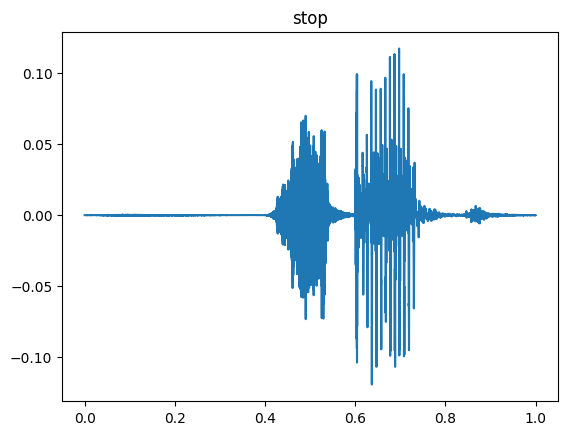

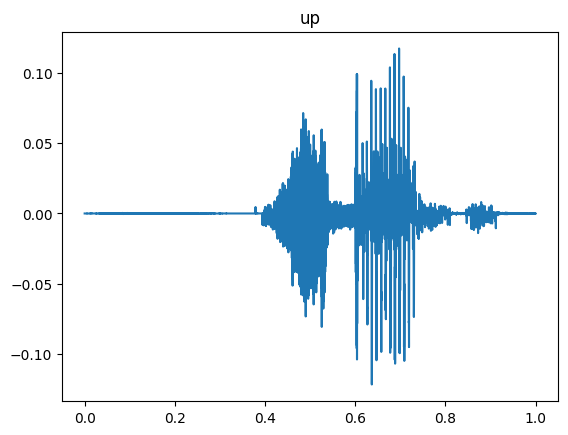

In [145]:
org_wave = Wave(ys=x[0,:,0].numpy(), framerate=16000)
org_cls = test_ds.class_names[tf.math.argmax(model(tf_stft(x, y)[0])[0]).numpy()]
# print(org_cls)
org_wave.plot()
plt.title(str(org_cls))
plt.show()
display(org_wave.make_audio())
adv_wave = Wave(ys=adv_x[0,:,0].numpy(), framerate=16000)
adv_cls = test_ds.class_names[tf.math.argmax(model(tf_stft(adv_x, y)[0])[0]).numpy()]
# print(adv_cls)
adv_wave.plot()
plt.title(str(adv_cls))
plt.show()
display(adv_wave.make_audio())

In [147]:
tx, ty = tf_stft(x,y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


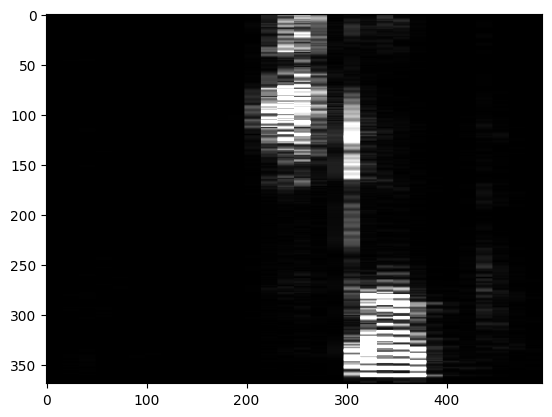

In [149]:
plt.imshow(tx[0].numpy())
plt.show()

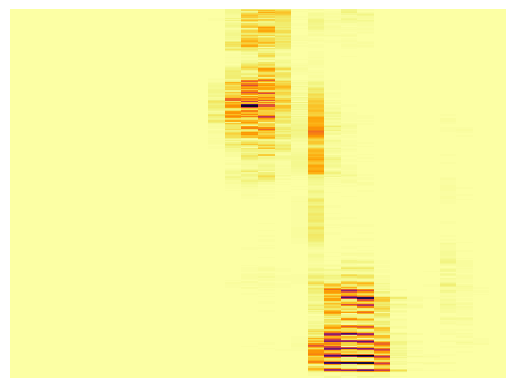

In [173]:
plt.imshow(img)
plt.show()

In [110]:
import os
from tqdm.notebook import tqdm

ys = []
adv_ys = []
for i, (x, y) in tqdm(enumerate(test_ds), total=len(test_ds)):
    adv_x, cls = gen_adv(x,y)
    if cls is not None:
        ys.append(y[0].numpy())
        adv_ys.append(cls.numpy())
        
    adv_wave = Wave(ys=adv_x[0,:,0].numpy(), framerate=16000)
    
    # Save augmented audio
    adv_audio_path = os.path.join(
            'adv_audio',
            test_ds.class_names[y[0]],
            f'{i}.wav'
    )
    os.makedirs(os.path.dirname(adv_audio_path), exist_ok=True)
#     print(adv_audio_path)
    
    WavFileWriter(filename=adv_audio_path, framerate=adv_wave.framerate).write(adv_wave)

  0%|          | 0/1599 [00:00<?, ?it/s]

Success rate of adversarial attack.

In [117]:
1 - np.sum(np.array(ys) == np.array(adv_ys)) / len(ys)

0.8723618090452261

In [112]:
import re

def rename(path):
    path = re.sub(r'adv_audio', 'adv_spec', path)
    path = re.sub(r'wav$', 'png', path)
    
    return path

def wav_to_png(path):
    wave = read_wave(path)
    spectrogram = wave.make_spectrogram(seg_length=1024)
    spectrogram.plot(high=5000)

    # Save spectrogram
    plt.axis('off')
    png_path = rename(path)
    os.makedirs(os.path.dirname(png_path), exist_ok=True)
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0)

In [113]:
from pathlib import Path
import multiprocessing as mp

wavs = list(map(str, Path('adv_audio').rglob('*.wav')))


In [114]:

with mp.Pool() as pool:
    pool.map(wav_to_png, tqdm(wavs))

  0%|          | 0/1599 [00:00<?, ?it/s]